In [1]:
from pymatreader import read_mat
from scipy import signal
import pandas as pd
import numpy as np
import scipy.io as sio
from tqdm.auto import tqdm

d:\Anaconda\envs\py3-TF2.0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
 pd.__version__

'1.5.3'

In [68]:

def standardise(data,ms): #Calculates mean of each subcarrier
    data = np.array(data).flatten()
    combined = list(zip(ms, data))
    resultList = []
    for value in combined:
        standardise = lambda x, y, z: (x-y)/z
        csistd = np.frompyfunc(standardise, 3, 1)
        result = csistd(value[1],value[0][0],value[0][1])
        resultList.append(result)
    return resultList

def meanstd(df):
    test = df['Filtered'].copy()
    test = test.dropna(axis=0)
    for i in range(0, len(test)):
        test[i] = test[i].flatten()
    test = test.to_numpy()
    meanstd = [(np.mean(sample), np.std(sample)) for sample in test]
    return meanstd

def segmentation(df):
    #Window size is 256, stride is 128
    segmented = pd.DataFrame({'Range': 'string', 'Sample': []})
    stride = 128
    startIndex = 0
    lastIndex = 256
    while(lastIndex < df.shape[0]):
        # CHANGE THIS FOR NORMAL - It should be df['standardised']
        sample = df['Standardised']
        sample = sample.iloc[startIndex:lastIndex].to_numpy()
        index = '{}-{}'.format(startIndex, lastIndex)
        newRow = pd.Series({'Range' : index, 'Sample' : sample})
        segmented = pd.concat([segmented, newRow.to_frame().T], ignore_index=True)
        startIndex += stride
        lastIndex += stride
    return segmented

# Filtering method is modified from https://github.com/Gi-z/CSIKit/blob/master/CSIKit/filters/passband.py
def filter(csi):
    nyq = 0.5*100 #Sampled at 100Hz
    low = 10/nyq #Cutoff below 10Hz
    high = 90/nyq
    b, a = signal.butter(2, [low,high], btype ='bandpass', analog=False, fs=100)
    return csi.apply(lambda csi: signal.filtfilt(b,a, csi))
    
def preprocess(df, active, steady):
    # print('In preprocessing')
    preprocessed = pd.DataFrame({'Range': '', 'Sample': [], 'Label': ''})
    #Extracting the amplitude
    df['CSI'] = np.abs(df['CSI'])
    #Filtering with low pass
    df['Filtered'] = filter(df['CSI'])
    meanstdlist = meanstd(df)
    #Using the equation from CSITime, standardize each sample
    df['Standardised'] = [standardise(sample, meanstdlist) for sample in df["Filtered"]]
    df.drop("CSI", inplace = True, axis = 1)
    
    #Separate the sample to the active and steady state
    intF = df.loc[df["label"] == '{}'.format(active)]
    intS = df.loc[df["label"] == '{}'.format(steady)]
    # print(intS.head())
    # print('Grouped')
    segmentF = segmentation(intF)
    segmentF['Label'] = [active for sample in segmentF['Range']]
    segmentS = segmentation(intS)
    segmentS['Label'] = [steady for sample in segmentS['Range']]
    
    # print('Segmented')
    preprocessed = pd.concat([preprocessed, segmentF], ignore_index=True)
    preprocessed = pd.concat([preprocessed, segmentS], ignore_index=True)
    
    # print('Preprocessed')

    return preprocessed

In [69]:
data = {}
# subjectPair = ['S1_S47', 'S2_S22', 'S3_S44', 'S4_S15','S6_S24', 'S7_S12','S8_S31','S13_S21', 'S14_S5', 'S16_S41','S18_S57','S19_S11','S20_S61',
#                'S25_S9','S26_S60', 'S27_S40','S28_S43','S32_S64', 'S33_S3','S34_S30','S35_S52','S36_S16','S37_S54','S38_S35','S41_S36',
#                'S42_S14','S44_S33','S46_S28','S48_S45','S49_S10','S50_S17','S51_S23','S52_S62','S53_S12','S55_S66','S56_S63','S58_S39',
#                'S59_S29','S62_S38','S65_S42']

subjectPair = ['S1_S47', 'S2_S22', 'S3_S44', 'S4_S15','S6_S24', 'S7_S12','S8_S31','S13_S21', 'S14_S5', 'S16_S41','S18_S57','S19_S11','S20_S61',
               'S25_S9','S26_S60', 'S27_S40','S28_S43','S32_S64', 'S33_S3','S34_S30']

interactions = [1,3,5,7,9,11]
final = pd.DataFrame({'Range': 'string', 'Sample': [], 'Label': ''}) 

for pair in tqdm(subjectPair, desc='subjectPair', leave=True): #Iterate through each pair
    for intera in interactions: #Index of interaction
        for trial in range(1,6): #Index of trial
            # print(('C:\\Users\\Karlj\\dissertation\\wifimod\\{0}\\I{1}\\{0}_I{1}_T{2}.mat'.format(pair, intera, trial)))
            data = read_mat('C:\\Users\\Karlj\\dissertation\\wifimod\\{0}\\I{1}\\{0}_I{1}_T{2}.mat'.format(pair, intera, trial))
            df = pd.DataFrame(data['Raw_Cell_Matrix'])
            df.drop(['Nrx', 'Ntx', 'noise','agc','RSSI_a', 'RSSI_b','RSSI_c', "timestamp_low"], axis=1, inplace=True)
            active = 'I{}'.format(intera)
            preprocessed = preprocess(df, active, 'I13')
            df.dropna(axis=0)
            final = pd.concat([final, preprocessed], ignore_index=True)

final.to_pickle('csi-dataset-20-7-5-newpreprocwfil.pkl')
                      

subjectPair: 100%|██████████| 20/20 [25:16<00:00, 75.81s/it]


In [72]:
final.head()

,Range,Sample,Label
0,0-256,"[[-0.13451004535344363, 0.12838563559902852, 0...",I1
1,128-384,"[[0.07193086177236424, 0.3231977634111189, 0.3...",I1
2,256-512,"[[-1.3067381127893876, -1.0848196729527737, -0...",I1
3,384-640,"[[-1.0227428785940231, -0.7187833185795163, -0...",I1
4,512-768,"[[-0.8880415965639372, -0.6416270344192866, -0...",I1


In [70]:
import matplotlib.pyplot as plt

testpl = final['Sample'][0].copy()
# testpl = df['CSI'].copy()
# testpl = np.transpose(testpl)
# print(testpl)
testpl = np.column_stack(testpl) #Each array is the ith jth subcarrier of every sample


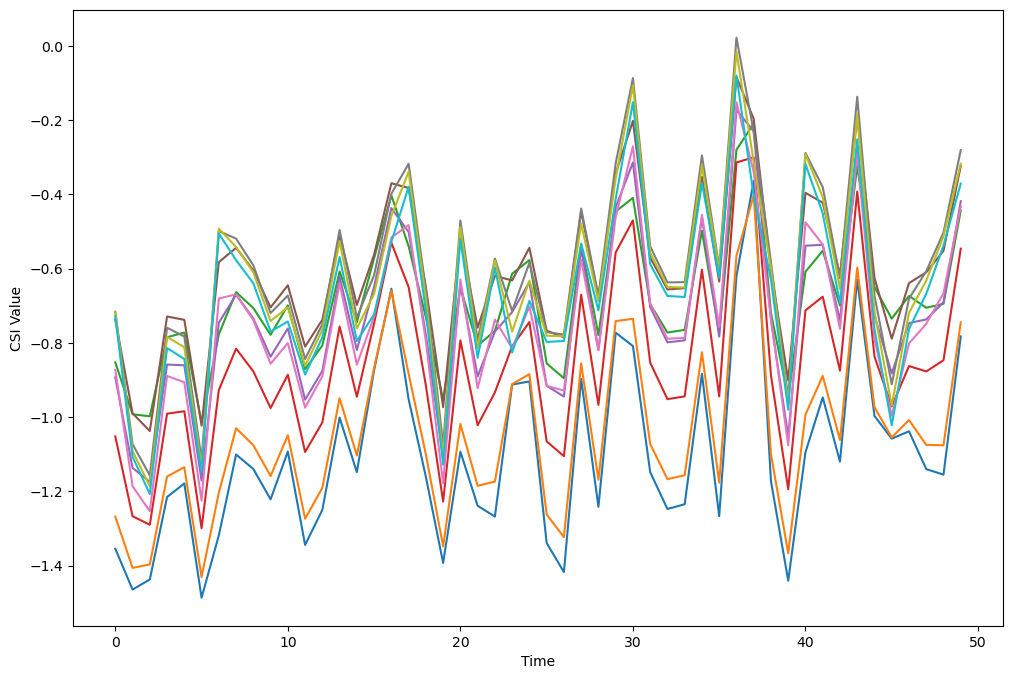

In [83]:
plt.figure(figsize=(12,8))
x = range(0,50)
for i in range(150,160):
    # y = testpl[0][400:450]
    y = testpl[i][0:50]
    plt.plot(x, y)

plt.xlabel('Time')
plt.ylabel('CSI Value')
plt.show()